# Project 8: Backtesting

In this project, you will build a fairly realistic backtester that uses the Barra data. The backtester will perform portfolio optimization that includes transaction costs, and you'll implement it with computational efficiency in mind, to allow for a reasonably fast backtest. You'll also use performance attribution to identify the major drivers of your portfolio's profit-and-loss (PnL). You will have the option to modify and customize the backtest as well.


### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

### Load Packages

In [2]:
import scipy
import patsy
import pickle

import numpy as np
import pandas as pd

import scipy.sparse
import matplotlib.pyplot as plt

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols
from tqdm import tqdm

## Load Data

We’ll be using the Barra dataset to get factors that can be used to predict risk. Loading and parsing the raw Barra data can be a very slow process that can significantly slow down your backtesting. For this reason, it's important to pre-process the data beforehand. For your convenience, the Barra data has already been pre-processed for you and saved into pickle files. You will load the Barra data from these pickle files.

In the code below, we start by loading `2004` factor data from the `pandas-frames.2004.pickle` file. We also load the `2003` and `2004` covariance data from the `covaraince.2003.pickle`  and `covaraince.2004.pickle` files. You are encouraged  to customize the data range for your backtest. For example, we recommend starting with two or three years of factor data. Remember that the covariance data should include all the years that you choose for the factor data,   and also one year earlier. For example, in the code below we are using  `2004` factor data, therefore, we must include `2004` in our covariance data, but also the previous year, `2003`. If you don't remember why must include this previous year, feel free to review the lessons.

In [3]:
barra_dir = '../../data/project_8_barra/'

data = {}
for year in [2004]:
    fil = barra_dir + "pandas-frames." + str(year) + ".pickle"
    data.update(pickle.load( open( fil, "rb" ) ))
    
covariance = {}
for year in [2003, 2004]:
    fil = barra_dir + "covariance." + str(year) + ".pickle"
    covariance.update(pickle.load( open(fil, "rb" ) ))
    
daily_return = {}
for year in [2004, 2005]:
    fil = barra_dir + "price." + str(year) + ".pickle"
    daily_return.update(pickle.load( open(fil, "rb" ) ))

## Shift Daily Returns Data (TODO)

In the cell below, we want to incorporate a realistic time delay that exists in live trading, we’ll use a two day delay for the `daily_return` data. That means the `daily_return` should be two days after the data in `data` and `cov_data`. Combine `daily_return` and `data` together in a dict called `frames`.

Since reporting of PnL is usually for the date of the returns, make sure to use the two day delay dates (dates that match the `daily_return`) when building `frames`. This means calling `frames['20040108']` will get you the prices from "20040108" and the data from `data` at "20040106".

Note: We're not shifting `covariance`, since we'll use the "DataDate" field in `frames` to lookup the covariance data. The "DataDate" field contains the date when the `data` in `frames` was recorded. For example, `frames['20040108']` will give you a value of "20040106" for the field "DataDate".

In [4]:
daily_return.items()

dict_items([('20040102',         Barrid  DlyReturn
76     USA0001   0.000000
77     USA0011   0.000000
78     USA0031   0.000000
79     USA0062   0.000000
80     USA00E2   0.000000
81     USA00F1   0.000000
82     USA00G2   0.000000
83     USA00H1   0.000000
84     USA00I1   0.000000
85     USA00J1   0.000000
86     USA00K1   0.000000
87     USA00P1   0.000000
88     USA00R1   0.000000
89     USA00S1  -0.009555
90     USA00V1   0.000000
91     USA0131   0.000000
92     USA0161   0.000000
93     USA01I1   0.000000
94     USA01J2   0.000000
95     USA01L1   0.000000
96     USA01P1   0.000000
97     USA01Q1   0.000000
98     USA0202   0.000000
99     USA0231   0.000000
100    USA0281   0.000000
101    USA0291   0.000000
102    USA02A1   0.000000
103    USA02B1   0.083078
104    USA02H1   0.000000
105    USA02P1   0.000000
...        ...        ...
12488  USAZY41   0.000000
12489  USAZY51   0.000000
12490  USAZY61   0.000000
12491  USAZY71   0.000000
12492  USAZYI1  -0.142857
12493  USAZYJ

In [5]:
frames ={}
dlyreturn_n_days_delay = 2

date_shifts = zip( sorted(data.keys()),
        sorted(daily_return.keys())[dlyreturn_n_days_delay:len(data) + dlyreturn_n_days_delay])

for data_date, price_date in date_shifts:
    frames[price_date] =data[data_date].merge(daily_return[price_date], on='Barrid')


## Add Daily Returns date column (Optional)
Name the column `DlyReturnDate`.
**Hint**: create a list containing copies of the date, then create a pandas series.

In [7]:
# Optional
for DlyReturnDate, df in daily_return.items():
    n_row = df.shape[0]
    df['DlyReturnDate'] = pd.Series([DlyReturnDate]*n_row)


## Winsorize

As we have done in other projects, we'll want to avoid extremely positive or negative values in our data. Will therefore create a function, `wins`, that will clip our values to a minimum and maximum range. This process is called **Winsorizing**. Remember that this helps us handle noise, which may otherwise cause unusually large positions.

In [8]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

## Density Plot

Let's check our `wins` function by taking a look at the distribution of returns for a single day `20040102`. We will clip our data from `-0.1` to `0.1` and plot it using our `density_plot` function.

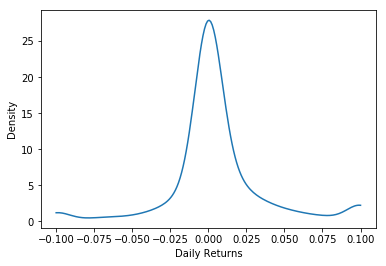

In [9]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
test = frames['20040108']
test['DlyReturn'] = wins(test['DlyReturn'],-0.1,0.1)
density_plot(test['DlyReturn'])

## Factor Exposures and Factor Returns

Recall that:

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. Since we get the factor exposures from the Barra data, and we know the returns, it is possible to estimate the factor returns. In this notebook, we will use the Ordinary Least Squares (OLS) method to estimate the factor exposures, $f_{j,t}$, by using $\beta_{i,j,t-2}$ as the independent variable, and $r_{i,t}$ as the dependent variable.

In [10]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: "USFASTD_" in x, n))

def estimate_factor_returns(df): 
    ## build universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  
    ## winsorize returns for fitting 
    estu['DlyReturn'] = wins(estu['DlyReturn'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturn")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [11]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params

In [12]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))

## Choose Alpha Factors

We will now choose our alpha factors. Barra's factors include some alpha factors that we have seen before, such as:

* **USFASTD_1DREVRSL** : Reversal

* **USFASTD_EARNYILD** : Earnings Yield

* **USFASTD_VALUE** : Value

* **USFASTD_SENTMT** : Sentiment

We will choose these alpha factors for now, but you are encouraged to come back to this later and try other factors as well.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


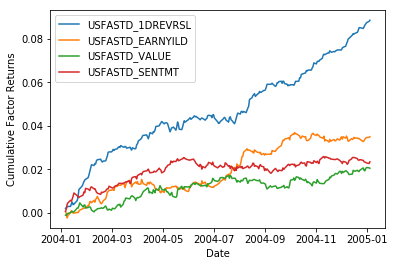

In [13]:
alpha_factors = ["USFASTD_1DREVRSL", "USFASTD_EARNYILD", "USFASTD_VALUE", "USFASTD_SENTMT"]

facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

## Merge Previous Portfolio Holdings 

In order to optimize our portfolio we will use the previous day's holdings to estimate the trade size and transaction costs. In order to keep track of the holdings from the previous day we will include a column to hold the portfolio holdings of the previous day. These holdings of all our assets will be initialized to zero when the backtest first starts.

In [14]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

In [15]:
previous_holdings = pd.DataFrame(data = {"Barrid" : ["USA02P1"], "h.opt.previous" : np.array(0)})
df = frames[my_dates[0].strftime('%Y%m%d')]

df = df.merge(previous_holdings, how = 'left', on = 'Barrid')
df = clean_nas(df)
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])

In [16]:
df.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,h.opt.previous
0,USA0001,-0.032,0.000,0.0,0.0,0.0,0.0,0.0,-2.177,0.0,...,0.0,5.392988e+10,0.188679,13.959397,9.014505,-0.000189,0.156387,20040102,0.0,0.0
1,USA0011,-0.059,0.000,0.0,0.0,0.0,0.0,0.0,-2.176,0.0,...,0.0,5.874999e+09,0.000000,17.033359,11.726327,0.000013,0.147900,20040102,0.0,0.0
2,USA0031,0.457,0.000,0.0,0.0,0.0,0.0,0.0,-2.061,0.0,...,0.0,7.304963e+10,2.103004,21.738218,18.047415,0.053033,0.216422,20040102,0.0,0.0
3,USA0062,-0.128,0.431,0.0,0.0,0.0,0.0,0.0,-2.003,0.0,...,0.0,2.866562e+10,2.243494,23.129496,20.830128,0.079755,0.355564,20040102,0.0,0.0
4,USA00E2,0.374,0.000,0.0,0.0,0.0,0.0,0.0,-1.967,0.0,...,0.0,5.720420e+10,2.167256,25.391653,21.458171,0.096238,0.412602,20040102,0.0,0.0


## Build Universe Based on Filters (TODO)

In the cell below, implement the function `get_universe` that creates a stock universe by selecting only those companies that have a market capitalization of at least 1 billion dollars **OR** that are in the previous day's holdings, even if on the current day, the company no longer meets the 1 billion dollar criteria.

When creating the universe, make sure you use the `.copy()` attribute to create a copy of the data. Also, it is very important to make sure that we are not looking at returns when forming the portfolio! to make this impossible, make sure to drop the column containing the daily return.

In [18]:
def get_universe(df):
    """
    Create a stock universe based on filters

    Parameters
    ----------
    df : DataFrame
        All stocks
        
    Returns
    -------
    universe : DataFrame
        Selected stocks based on filters
    """
    
    universe = df.loc[(df['IssuerMarketCap']> 1e9) | (df['h.opt.previous'] != 0)].copy()
    universe.drop(columns = ['DlyReturn'])
    return universe

universe = get_universe(df)

In [19]:
date = str(int(universe['DataDate'][1])) 

## Factors

We will now extract both the risk factors and alpha factors. We begin by first getting all the factors using the `factors_from_names` function defined previously.

In [20]:
all_factors = factors_from_names(list(universe))

We will now create the function `setdiff` to just select the factors that we have not defined as alpha factors

In [21]:
def setdiff(temp1, temp2): 
    s = set(temp2)
    temp3 = [x for x in temp1 if x not in s]
    return temp3

In [22]:
risk_factors = setdiff(all_factors, alpha_factors)

We will also save the column that contains the previous holdings in a separate variable because we are going to use it later when we perform our portfolio optimization.

In [23]:
h0 = universe['h.opt.previous']

## Matrix of Risk Factor Exposures

Our dataframe contains several columns that we'll use as risk factors exposures.  Extract these and put them into a matrix.

The data, such as industry category, are already one-hot encoded, but if this were not the case, then using `patsy.dmatrices` would help, as this function extracts categories and performs the one-hot encoding.  We'll practice using this package, as you may find it useful with future data sets.  You could also store the factors in a dataframe if you prefer.

#### How to use patsy.dmatrices

`patsy.dmatrices` takes in a formula and the dataframe.  The formula tells the function which columns to take.  The formula will look something like this:  
`SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + ...`  
where the variable to the left of the ~ is the "dependent variable" and the others to the right are the independent variables (as if we were preparing data to be fit to a model).

This just means that the `pasty.dmatrices` function will return two matrix variables, one that contains the single column for the dependent variable `outcome`, and the independent variable columns are stored in a matrix `predictors`.

The `predictors` matrix will contain the matrix of risk factors, which is what we want.  We don't actually need the `outcome` matrix; it's just created because that's the way patsy.dmatrices works.

In [24]:
formula = get_formula(risk_factors, "SpecRisk")

In [25]:
def model_matrix(formula, data): 
    outcome, predictors = patsy.dmatrices(formula, data)
    return predictors

In [26]:
B = model_matrix(formula, universe)
BT = B.transpose()

## Calculate Specific Variance

Notice that the specific risk data is in percent:

In [27]:
universe['SpecRisk'][0:2]

0     9.014505
1    11.726327
Name: SpecRisk, dtype: float64

Therefore, in order to get the specific variance for each stock in the universe we first need to multiply these values by `0.01`  and then square them:

In [28]:
specVar = (0.01 * universe['SpecRisk']) ** 2

## Factor covariance matrix (TODO)

Note that we already have factor covariances from Barra data, which is stored in the variable `covariance`.  `covariance` is a dictionary, where the key is each day's date, and the value is a dataframe containing the factor covariances.

In [29]:
covariance['20040102'].head()

,Factor1,Factor2,VarCovar,DataDate
0,USFASTD_1DREVRSL,USFASTD_1DREVRSL,1.958869,20040102
1,USFASTD_1DREVRSL,USFASTD_BETA,1.602458,20040102
2,USFASTD_1DREVRSL,USFASTD_DIVYILD,-0.012642,20040102
3,USFASTD_1DREVRSL,USFASTD_DWNRISK,-0.064387,20040102
4,USFASTD_1DREVRSL,USFASTD_EARNQLTY,0.046573,20040102


In the code below, implement the function `diagonal_factor_cov` to create the factor covariance matrix. Note that the covariances are given in percentage units squared.  Therefore you must re-scale them appropriately so that they're in decimals squared. Use the given `colnames` function to get the column names from `B`. 

When creating factor covariance matrix, you can store the factor variances and covariances, or just store the factor variances.  Try both, and see if you notice any differences.

In [30]:
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

In [31]:
def NCOL(x):
    return(np.shape(x)[1])

In [50]:
def get_var(cv, factor): 
    return(cv.loc[(cv.Factor1== factor) & (cv.Factor2== factor),"VarCovar"].iloc[0])

In [51]:
def diagonal_factor_cov(date, B):
    """
    Create the factor covariance matrix

    Parameters
    ----------
    date : string
           date. For example 20040102
        
    B : patsy.design_info.DesignMatrix OR pandas.core.frame.DataFrame
        Matrix of Risk Factors
        
    Returns
    -------
    Fm : Numpy ndarray
        factor covariance matrix
    """
    
    cv = covariance[date]
    k = NCOL(B)
    Fm = np.zeros([k,k])
    for j in range(0,k): 
        fac = colnames(B)[j]
        Fm[j,j] = (0.01**2) * get_var(cv, fac)
    return(Fm)
    

Fvar = diagonal_factor_cov(date, B)

## Transaction Costs

To get the transaction cost, or slippage, we have to multiply the price change due to market impact by the amount of dollars traded:

$$
\mbox{tcost_{i,t}} = \% \Delta \mbox{price}_{i,t} \times \mbox{trade}_{i,t}
$$

In summation notation it looks like this:  
$$
\mbox{tcost}_{i,t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2
$$  
where
$$
\lambda_{i,t} = \frac{1}{10\times \mbox{ADV}_{i,t}}
$$

Note that since we're dividing by ADV, we'll want to handle cases when ADV is missing or zero.  In those instances, we can set ADV to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid. In the code below if there is no volume information we assume the asset is illiquid.

In [52]:
def get_lambda(universe, composite_volume_column = 'ADTCA_30'):
    universe.loc[np.isnan(universe[composite_volume_column]), composite_volume_column] = 1.0e4
    universe.loc[universe[composite_volume_column] == 0, composite_volume_column] = 1.0e4 

    adv = universe[composite_volume_column]
    
    return 0.1 / adv

Lambda = get_lambda(universe)

## Alpha Combination (TODO)

In the code below create a matrix of alpha factors and return it from the function `get_B_alpha`. Create this matrix in the same way you created the matrix of risk factors, i.e. using the `get_formula` and `model_matrix` functions we have defined above. Feel free to go back and look at the previous code.

In [53]:
def get_B_alpha(alpha_factors, universe):
    
    return model_matrix(get_formula(alpha_factors, "SpecRisk"), data = universe)

B_alpha = get_B_alpha(alpha_factors, universe)

Now that you have the matrix containing the alpha factors we will combine them by adding its rows. By doing this we will collapse the `B_alpha` matrix into a single alpha vector. We'll multiply by `1e-4` so that the expression of expected portfolio return, $\alpha^T \mathbf{h}$, is in dollar units. 

In [54]:
def get_alpha_vec(B_alpha):
    """
    Create an alpha vecrtor

    Parameters
    ----------        
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    Returns
    -------
    alpha_vec : patsy.design_info.DesignMatrix 
        alpha vecrtor
    """
    
    
    return 1e-4*np.sum(B_alpha, axis=1)

alpha_vec = get_alpha_vec(B_alpha)

#### Optional Challenge

You can also try to a more sophisticated method of alpha combination, by choosing the holding for each alpha based on the same metric of its performance, such as the factor returns, or sharpe ratio.  To make this more realistic, you can calculate a rolling average of the sharpe ratio, which is updated for each day.  Remember to only use data that occurs prior to the date of each optimization, and not data that occurs in the future.  Also, since factor returns and sharpe ratios may be negative, consider using a `max` function to give the holdings a lower bound of zero.

## Objective function (TODO)

The objective function is given by:

$$
f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})
$$

Where the terms correspond to: factor risk + idiosyncratic risk - expected portfolio return + transaction costs, respectively. We should also note that $\textbf{Q}^T\textbf{Q}$ is defined to be the same as $\textbf{BFB}^T$.  Review the lessons if you need a refresher of how we get $\textbf{Q}$.

Our objective is to minimize this objective function. To do this, we will use Scipy's optimization function:

`scipy.optimize.fmin_l_bfgs_b(func, initial_guess, func_gradient)`

where:

* **func** : is the function we want to minimize

* **initial_guess** : is out initial guess

* **func_gradient** : is the gradient of the function we want to minimize

So, in order to use the `scipy.optimize.fmin_l_bfgs_b` function we first need to define its parameters.

In the code below implement the function `obj_func(h)` that corresponds to the objective function above that we want to minimize. We will set the risk aversion to be `1.0e-6`.

In [55]:
risk_aversion = 1.0e-6

def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        f = f = 0.0
        f += 0.5 * risk_aversion * np.sum( np.matmul(Q, h) ** 2 )
        f += 0.5 * risk_aversion * np.dot(h ** 2, specVar) #since Specific Variance is diagonal, don't have to do matmul
        f -= np.dot(h, alpha_vec)
        f += np.dot( (h - h0) ** 2, Lambda)
        
        return f
    
    return obj_func

## Gradient (TODO)

Now that we can generate the objective function using `get_obj_func`, we can now create a similar function with its gradient. The reason we're interested in calculating the gradient is so that we can tell the optimizer in which direction, and how much, it should shift the portfolio holdings in order to improve the objective function (minimize variance, minimize transaction cost, and maximize expected portfolio return).

Before we implement the function we first need to know what the gradient looks like. The gradient, or derivative of the objective function, with respect to the portfolio holdings h, is given by:  

$$
f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}
$$

In the code below, implement the function `grad(h)` that corresponds to the function of the gradient given above.

In [56]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        g = risk_aversion * (np.matmul(QT, np.matmul(Q,h)) + (specVar * h) ) - alpha_vec  + 2 * (h-h0) * Lambda
        return np.asarray(g)
    
    return grad_func

## Optimize (TODO)

Now that we can generate the objective function using `get_obj_func`, and its corresponding gradient using `get_grad_func` we are ready to minimize the objective function using Scipy's optimization function. For this, we will use out initial holdings as our `initial_guess` parameter.

In the cell below, implement the function `get_h_star` that optimizes the objective function. Use the objective function (`obj_func`) and gradient function (`grad_func`) provided within `get_h_star` to optimize the objective function using the `scipy.optimize.fmin_l_bfgs_b` function.

In [57]:
risk_aversion = 1.0e-6

Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()

def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)
    
    func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)
    optimizer_result = scipy.optimize.fmin_l_bfgs_b(func, h0, fprime=grad)

    return optimizer_result[0]

h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)

After we have optimized our objective function we can now use, `h_star` to create our optimal portfolio:

In [58]:
opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})

## Risk Exposures (TODO)

We can also use `h_star` to calculate our portfolio's risk and alpha exposures.

In the cells below implement the functions `get_risk_exposures` and `get_portfolio_alpha_exposure` that calculate the portfolio's risk and alpha exposures, respectively.

In [74]:
def get_risk_exposures(B, BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    
    
    return pd.Series(np.matmul(BT, h_star), index = colnames(B))

risk_exposures = get_risk_exposures(B, BT, h_star)

In [60]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    
    
    return pd.Series(np.matmul(B_alpha.transpose(), h_star), index = colnames(B_alpha))

portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)

## Transaction Costs (TODO)

We can also use `h_star` to calculate our total transaction costs:
$$
\mbox{tcost} = \sum_i^{N} \lambda_{i} (h_{i,t} - h_{i,t-1})^2
$$

In the cell below, implement the function `get_total_transaction_costs` that calculates the total transaction costs according to the equation above:

In [61]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    
    return ((h_star - h0)**2).dot(Lambda)

total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)

## Putting It All Together

We can now take all the above functions we created above and use them to create a single function, `form_optimal_portfolio` that returns the optimal portfolio, the risk and alpha exposures, and the total transactions costs.

In [62]:
def form_optimal_portfolio(df, previous, risk_aversion):
    df = df.merge(previous, how = 'left', on = 'Barrid')
    df = clean_nas(df)
    df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
  
    universe = get_universe(df)
    date = str(int(universe['DataDate'][1]))
  
    all_factors = factors_from_names(list(universe))
    risk_factors = setdiff(all_factors, alpha_factors)
  
    h0 = universe['h.opt.previous']
  
    B = model_matrix(get_formula(risk_factors, "SpecRisk"), universe)
    BT = B.transpose()
  
    specVar = (0.01 * universe['SpecRisk']) ** 2
    Fvar = diagonal_factor_cov(date, B)
    
    Lambda = get_lambda(universe)
    B_alpha = get_B_alpha(alpha_factors, universe)
    alpha_vec = get_alpha_vec(B_alpha)
  
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
    opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
    
    risk_exposures = get_risk_exposures(B, BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

## Build tradelist

The trade list is the most recent optimal asset holdings minus the previous day's optimal holdings.

In [63]:
def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'Barrid')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

## Save optimal holdings as previous optimal holdings.

As we walk through each day, we'll re-use the column for previous holdings by storing the "current" optimal holdings as the "previous" optimal holdings.

In [64]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

## Run the backtest

Walk through each day, calculating the optimal portfolio holdings and trade list.  This may take some time, but should finish sooner if you've chosen all the optimizations you learned in the lessons.

In [75]:
trades = {}
port = {}

for dt in tqdm(my_dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime('%Y%m%d')

    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio: 100%|██████████| 252/252 [26:23<00:00,  6.28s/day]


## Profit-and-Loss (PnL) attribution (TODO)

Profit and Loss is the aggregate realized daily returns of the assets, weighted by the optimal portfolio holdings chosen, and summed up to get the portfolio's profit and loss.

The PnL attributed to the alpha factors equals the factor returns times factor exposures for the alpha factors.  

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Similarly, the PnL attributed to the risk factors equals the factor returns times factor exposures of the risk factors.

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In the code below, in the function `build_pnl_attribution` calculate the PnL attributed to the alpha factors, the PnL attributed to the risk factors, and attribution to cost. 

In [76]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        fr = facret[date]
        print(p['risk.exposures'])
        mf = p['opt.portfolio'].merge(frames[date], how = 'left', on = "Barrid")
        
        mf['DlyReturn'] = wins(mf['DlyReturn'], -0.5, 0.5)
        df.at[dt,"daily.pnl"] = np.sum(mf['h.opt'] * mf['DlyReturn'])
        
    
        df.at[dt,"attribution.alpha.pnl"] = partial_dot_product(fr,p['alpha.exposures'])
        df.at[dt,"attribution.risk.pnl"] = partial_dot_product(fr,p['risk.exposures'])
        df.at[dt,"attribution.cost"] = p['total.cost']
        
    return df

USFASTD_AERODEF      -3590.881526
USFASTD_AIRLINES       940.674133
USFASTD_ALUMSTEL     -6672.630632
USFASTD_APPAREL       4717.938036
USFASTD_AUTO          4632.509383
USFASTD_BANKS        14081.613788
USFASTD_BETA         -7174.501117
USFASTD_BEVTOB       -7634.419553
USFASTD_BIOLIFE      -7780.801514
USFASTD_BLDGPROD       591.317791
USFASTD_CHEM         -9561.775150
USFASTD_CNSTENG       4906.271301
USFASTD_CNSTMACH      1237.785976
USFASTD_CNSTMATL      2698.447862
USFASTD_COMMEQP      -2970.871275
USFASTD_COMPELEC       678.200954
USFASTD_COMSVCS     -20228.124650
USFASTD_CONGLOM       1418.418853
USFASTD_CONTAINR     -5123.995503
USFASTD_DISTRIB       6617.920870
USFASTD_DIVFIN        6003.438417
USFASTD_DIVYILD     -44622.237300
USFASTD_DWNRISK      14058.871226
USFASTD_EARNQLTY   -226052.546794
USFASTD_ELECEQP      -3178.994617
USFASTD_ELECUTIL     12930.657313
USFASTD_FOODPROD     -5113.539051
USFASTD_FOODRET       4838.207716
USFASTD_GASUTIL       5346.320529
USFASTD_GROWTH

USFASTD_AERODEF      -2344.467626
USFASTD_AIRLINES       618.818846
USFASTD_ALUMSTEL         2.269123
USFASTD_APPAREL       1981.038702
USFASTD_AUTO          4959.641266
USFASTD_BANKS        11456.880138
USFASTD_BETA         -6381.608342
USFASTD_BEVTOB       -4506.495774
USFASTD_BIOLIFE      -5656.960126
USFASTD_BLDGPROD      3113.707530
USFASTD_CHEM         -4382.375446
USFASTD_CNSTENG       2652.657683
USFASTD_CNSTMACH      -131.756786
USFASTD_CNSTMATL      3107.255456
USFASTD_COMMEQP      -2288.754126
USFASTD_COMPELEC       -26.388539
USFASTD_COMSVCS     -14646.547776
USFASTD_CONGLOM       1095.309642
USFASTD_CONTAINR      -371.450104
USFASTD_DISTRIB       1820.647358
USFASTD_DIVFIN        7618.292248
USFASTD_DIVYILD      39853.856316
USFASTD_DWNRISK     -29674.988608
USFASTD_EARNQLTY   -140980.417414
USFASTD_ELECEQP       -554.323557
USFASTD_ELECUTIL      8445.744410
USFASTD_FOODPROD     -6510.106898
USFASTD_FOODRET       3122.145746
USFASTD_GASUTIL       2856.283176
USFASTD_GROWTH

USFASTD_AERODEF      -610.232822
USFASTD_AIRLINES      483.691523
USFASTD_ALUMSTEL       16.306789
USFASTD_APPAREL      1757.439702
USFASTD_AUTO         6311.395385
USFASTD_BANKS        5681.489282
USFASTD_BETA        -5042.151315
USFASTD_BEVTOB      -3679.654278
USFASTD_BIOLIFE     -3164.240381
USFASTD_BLDGPROD     4738.181325
USFASTD_CHEM        -1798.789303
USFASTD_CNSTENG      1269.497880
USFASTD_CNSTMACH      824.797987
USFASTD_CNSTMATL     3042.737848
USFASTD_COMMEQP     -1092.837805
USFASTD_COMPELEC    -1654.938152
USFASTD_COMSVCS     -8261.102089
USFASTD_CONGLOM       805.667945
USFASTD_CONTAINR     -168.942062
USFASTD_DISTRIB      1189.859872
USFASTD_DIVFIN      10580.269722
USFASTD_DIVYILD     25450.444712
USFASTD_DWNRISK     11445.443839
USFASTD_EARNQLTY   -69189.872468
USFASTD_ELECEQP      -196.072916
USFASTD_ELECUTIL     7804.127591
USFASTD_FOODPROD    -1399.545174
USFASTD_FOODRET      2588.560909
USFASTD_GASUTIL      2313.343235
USFASTD_GROWTH     -54962.156658
          

USFASTD_AERODEF     -1421.954138
USFASTD_AIRLINES      499.313932
USFASTD_ALUMSTEL     -570.652717
USFASTD_APPAREL       976.539734
USFASTD_AUTO         5406.753324
USFASTD_BANKS        9207.102553
USFASTD_BETA        -3097.839149
USFASTD_BEVTOB      -6471.670825
USFASTD_BIOLIFE     -4617.696884
USFASTD_BLDGPROD     3644.933621
USFASTD_CHEM         -334.512079
USFASTD_CNSTENG      2027.381340
USFASTD_CNSTMACH      511.924751
USFASTD_CNSTMATL     3783.477645
USFASTD_COMMEQP     -1517.166781
USFASTD_COMPELEC      156.842018
USFASTD_COMSVCS    -12195.190184
USFASTD_CONGLOM       292.173270
USFASTD_CONTAINR    -1283.109731
USFASTD_DISTRIB      1699.994666
USFASTD_DIVFIN       9091.795947
USFASTD_DIVYILD     15494.652986
USFASTD_DWNRISK     18790.462992
USFASTD_EARNQLTY   -69551.268071
USFASTD_ELECEQP     -2240.848502
USFASTD_ELECUTIL     6530.057846
USFASTD_FOODPROD    -2622.732710
USFASTD_FOODRET      3318.793728
USFASTD_GASUTIL      2802.157466
USFASTD_GROWTH     -81760.024015
          

USFASTD_AERODEF     -1585.404077
USFASTD_AIRLINES      520.417181
USFASTD_ALUMSTEL      669.497943
USFASTD_APPAREL      1889.428429
USFASTD_AUTO         5896.572291
USFASTD_BANKS        4481.962475
USFASTD_BETA        -5090.590905
USFASTD_BEVTOB      -7148.003134
USFASTD_BIOLIFE     -5970.121839
USFASTD_BLDGPROD     3618.234391
USFASTD_CHEM         -275.905792
USFASTD_CNSTENG      2493.383454
USFASTD_CNSTMACH      958.532533
USFASTD_CNSTMATL     1742.601229
USFASTD_COMMEQP     -2232.346165
USFASTD_COMPELEC      403.241780
USFASTD_COMSVCS     -9759.799030
USFASTD_CONGLOM       591.252772
USFASTD_CONTAINR     -257.635801
USFASTD_DISTRIB      2421.195317
USFASTD_DIVFIN       6832.848223
USFASTD_DIVYILD      7625.613502
USFASTD_DWNRISK     38471.691631
USFASTD_EARNQLTY   -87431.702835
USFASTD_ELECEQP     -3660.172917
USFASTD_ELECUTIL     6808.630758
USFASTD_FOODPROD    -4593.931975
USFASTD_FOODRET      2305.627537
USFASTD_GASUTIL      3480.415656
USFASTD_GROWTH     -77181.970472
          

USFASTD_AERODEF      -2202.284854
USFASTD_AIRLINES       634.922297
USFASTD_ALUMSTEL      1223.024920
USFASTD_APPAREL       2746.768373
USFASTD_AUTO          7200.230069
USFASTD_BANKS         6501.827008
USFASTD_BETA         -8235.761598
USFASTD_BEVTOB       -8185.732472
USFASTD_BIOLIFE      -8658.776381
USFASTD_BLDGPROD      4247.331568
USFASTD_CHEM          -198.891155
USFASTD_CNSTENG       1888.521713
USFASTD_CNSTMACH      3090.770748
USFASTD_CNSTMATL      5425.914978
USFASTD_COMMEQP        871.686975
USFASTD_COMPELEC      -719.457539
USFASTD_COMSVCS      -8288.498476
USFASTD_CONGLOM        297.307720
USFASTD_CONTAINR     -2562.389736
USFASTD_DISTRIB       5187.328706
USFASTD_DIVFIN        9186.739290
USFASTD_DIVYILD     -16887.150676
USFASTD_DWNRISK      35405.630417
USFASTD_EARNQLTY   -139057.896933
USFASTD_ELECEQP      -3742.604844
USFASTD_ELECUTIL      7829.081978
USFASTD_FOODPROD     -4581.900564
USFASTD_FOODRET       2658.907364
USFASTD_GASUTIL       3864.411880
USFASTD_GROWTH

USFASTD_AERODEF      -1566.146019
USFASTD_AIRLINES       891.623689
USFASTD_ALUMSTEL       281.946655
USFASTD_APPAREL       3302.870091
USFASTD_AUTO          8313.210915
USFASTD_BANKS         8572.008726
USFASTD_BETA         -5227.168302
USFASTD_BEVTOB       -8404.591340
USFASTD_BIOLIFE      -7159.060953
USFASTD_BLDGPROD      5558.889370
USFASTD_CHEM          -743.770279
USFASTD_CNSTENG       2857.104585
USFASTD_CNSTMACH      2286.733437
USFASTD_CNSTMATL      6744.649027
USFASTD_COMMEQP      -1898.806346
USFASTD_COMPELEC     -1490.578010
USFASTD_COMSVCS     -11913.900261
USFASTD_CONGLOM       -117.479976
USFASTD_CONTAINR     -1658.731494
USFASTD_DISTRIB       3610.155064
USFASTD_DIVFIN        6280.904329
USFASTD_DIVYILD     -30925.953303
USFASTD_DWNRISK      55661.013509
USFASTD_EARNQLTY   -198761.167183
USFASTD_ELECEQP       -227.661017
USFASTD_ELECUTIL      9435.609780
USFASTD_FOODPROD     -7104.347042
USFASTD_FOODRET       3783.976193
USFASTD_GASUTIL       5343.423323
USFASTD_GROWTH

USFASTD_AERODEF       -172.576090
USFASTD_AIRLINES      1863.528366
USFASTD_ALUMSTEL      1806.001837
USFASTD_APPAREL        853.376130
USFASTD_AUTO          9874.914012
USFASTD_BANKS        10053.541630
USFASTD_BETA         -1520.288127
USFASTD_BEVTOB       -6002.451433
USFASTD_BIOLIFE     -10690.539259
USFASTD_BLDGPROD      3470.505386
USFASTD_CHEM          1207.080203
USFASTD_CNSTENG       2990.365250
USFASTD_CNSTMACH      3722.029412
USFASTD_CNSTMATL      7155.657608
USFASTD_COMMEQP         -1.189500
USFASTD_COMPELEC      -154.095846
USFASTD_COMSVCS      -8424.326848
USFASTD_CONGLOM       2151.741877
USFASTD_CONTAINR     -2612.749310
USFASTD_DISTRIB       4336.384905
USFASTD_DIVFIN        6156.451024
USFASTD_DIVYILD      -9882.079686
USFASTD_DWNRISK      32364.316128
USFASTD_EARNQLTY   -178286.195854
USFASTD_ELECEQP       1708.356812
USFASTD_ELECUTIL     12337.292444
USFASTD_FOODPROD     -6459.663426
USFASTD_FOODRET       3633.905023
USFASTD_GASUTIL       2582.493801
USFASTD_GROWTH

USFASTD_AERODEF       -101.415411
USFASTD_AIRLINES       849.416169
USFASTD_ALUMSTEL       959.565262
USFASTD_APPAREL       2551.111577
USFASTD_AUTO          8137.740802
USFASTD_BANKS         8074.255602
USFASTD_BETA         -2617.769103
USFASTD_BEVTOB      -11064.036293
USFASTD_BIOLIFE     -11564.668210
USFASTD_BLDGPROD      5358.834677
USFASTD_CHEM          2767.992070
USFASTD_CNSTENG       3662.548852
USFASTD_CNSTMACH      2088.268255
USFASTD_CNSTMATL      4009.805476
USFASTD_COMMEQP       -824.489874
USFASTD_COMPELEC      1310.747121
USFASTD_COMSVCS     -10045.319557
USFASTD_CONGLOM       1987.582174
USFASTD_CONTAINR     -4295.702969
USFASTD_DISTRIB       4717.538519
USFASTD_DIVFIN        3873.813855
USFASTD_DIVYILD      -9123.381547
USFASTD_DWNRISK      39313.296244
USFASTD_EARNQLTY   -226346.008674
USFASTD_ELECEQP       4320.314044
USFASTD_ELECUTIL     10996.788127
USFASTD_FOODPROD     -6542.105240
USFASTD_FOODRET       2649.705909
USFASTD_GASUTIL       6472.452611
USFASTD_GROWTH

Length: 77, dtype: float64
USFASTD_AERODEF        685.808869
USFASTD_AIRLINES       185.090952
USFASTD_ALUMSTEL       828.360328
USFASTD_APPAREL        450.305390
USFASTD_AUTO          9685.661490
USFASTD_BANKS         1976.571024
USFASTD_BETA            29.522281
USFASTD_BEVTOB       -5568.663119
USFASTD_BIOLIFE     -10560.107396
USFASTD_BLDGPROD      2155.003402
USFASTD_CHEM           161.427207
USFASTD_CNSTENG       2658.991341
USFASTD_CNSTMACH       394.399746
USFASTD_CNSTMATL      4113.436474
USFASTD_COMMEQP       -954.369596
USFASTD_COMPELEC      1821.434194
USFASTD_COMSVCS     -11563.479886
USFASTD_CONGLOM       1952.847795
USFASTD_CONTAINR     -1388.620829
USFASTD_DISTRIB       3874.906039
USFASTD_DIVFIN        5603.417327
USFASTD_DIVYILD      97356.557116
USFASTD_DWNRISK      -3228.504992
USFASTD_EARNQLTY   -168502.160253
USFASTD_ELECEQP      -2481.257864
USFASTD_ELECUTIL      8941.607178
USFASTD_FOODPROD     -6106.065257
USFASTD_FOODRET       4018.782806
USFASTD_GASUTIL      

USFASTD_AERODEF       -403.737757
USFASTD_AIRLINES        84.145614
USFASTD_ALUMSTEL      1304.122153
USFASTD_APPAREL       1914.073701
USFASTD_AUTO         11288.895051
USFASTD_BANKS         5006.601298
USFASTD_BETA         -3198.204215
USFASTD_BEVTOB       -8682.849068
USFASTD_BIOLIFE     -10049.786091
USFASTD_BLDGPROD      8021.297626
USFASTD_CHEM           844.910707
USFASTD_CNSTENG       2562.702106
USFASTD_CNSTMACH      1624.608230
USFASTD_CNSTMATL      4443.912821
USFASTD_COMMEQP      -1627.295919
USFASTD_COMPELEC      2277.399618
USFASTD_COMSVCS     -14727.916237
USFASTD_CONGLOM       1464.092041
USFASTD_CONTAINR     -3625.051959
USFASTD_DISTRIB       3841.393761
USFASTD_DIVFIN        8169.912577
USFASTD_DIVYILD      38698.720619
USFASTD_DWNRISK       1560.387302
USFASTD_EARNQLTY   -189594.096991
USFASTD_ELECEQP      -1797.632573
USFASTD_ELECUTIL      9532.008730
USFASTD_FOODPROD     -9824.515275
USFASTD_FOODRET       1598.650958
USFASTD_GASUTIL       5329.740578
USFASTD_GROWTH

USFASTD_AERODEF        -36.320463
USFASTD_AIRLINES      -159.823675
USFASTD_ALUMSTEL      1117.982358
USFASTD_APPAREL       1638.394179
USFASTD_AUTO          5680.942052
USFASTD_BANKS         6921.951133
USFASTD_BETA         -7511.927009
USFASTD_BEVTOB       -8214.068352
USFASTD_BIOLIFE      -7651.521020
USFASTD_BLDGPROD      2367.333873
USFASTD_CHEM           231.582365
USFASTD_CNSTENG       1672.396361
USFASTD_CNSTMACH       686.857459
USFASTD_CNSTMATL      1011.728363
USFASTD_COMMEQP       -859.712349
USFASTD_COMPELEC      1118.908768
USFASTD_COMSVCS     -14937.196861
USFASTD_CONGLOM       1624.698166
USFASTD_CONTAINR      -617.346429
USFASTD_DISTRIB       2743.230251
USFASTD_DIVFIN        6638.452642
USFASTD_DIVYILD      30793.457088
USFASTD_DWNRISK      -3515.720447
USFASTD_EARNQLTY   -136659.713269
USFASTD_ELECEQP       1117.459263
USFASTD_ELECUTIL      5972.551831
USFASTD_FOODPROD     -7436.524423
USFASTD_FOODRET        104.665744
USFASTD_GASUTIL       3434.717340
USFASTD_GROWTH

USFASTD_AERODEF      -1082.869603
USFASTD_AIRLINES        45.836428
USFASTD_ALUMSTEL      1735.752143
USFASTD_APPAREL       1379.734898
USFASTD_AUTO          5236.370177
USFASTD_BANKS         2602.498260
USFASTD_BETA         -2487.171041
USFASTD_BEVTOB      -11909.885647
USFASTD_BIOLIFE      -6790.649004
USFASTD_BLDGPROD      3464.304045
USFASTD_CHEM           113.436604
USFASTD_CNSTENG        997.805343
USFASTD_CNSTMACH       385.616240
USFASTD_CNSTMATL      2136.224230
USFASTD_COMMEQP      -1233.280888
USFASTD_COMPELEC      2245.092134
USFASTD_COMSVCS     -16533.968046
USFASTD_CONGLOM       1758.467241
USFASTD_CONTAINR     -2458.110096
USFASTD_DISTRIB       2525.363070
USFASTD_DIVFIN        9653.583450
USFASTD_DIVYILD      52229.911655
USFASTD_DWNRISK     -42422.603025
USFASTD_EARNQLTY   -146818.777771
USFASTD_ELECEQP       -558.784556
USFASTD_ELECUTIL      8346.944934
USFASTD_FOODPROD    -10630.952518
USFASTD_FOODRET       -619.114701
USFASTD_GASUTIL       1017.483217
USFASTD_GROWTH

USFASTD_AERODEF         91.943263
USFASTD_AIRLINES       951.726996
USFASTD_ALUMSTEL      2080.236294
USFASTD_APPAREL       2154.211005
USFASTD_AUTO          6494.570542
USFASTD_BANKS         5448.992047
USFASTD_BETA          -155.771768
USFASTD_BEVTOB      -11411.194732
USFASTD_BIOLIFE      -7701.028293
USFASTD_BLDGPROD      4096.108250
USFASTD_CHEM           648.640090
USFASTD_CNSTENG       1307.605366
USFASTD_CNSTMACH      1597.808971
USFASTD_CNSTMATL      2950.028485
USFASTD_COMMEQP      -1305.175461
USFASTD_COMPELEC      4269.450698
USFASTD_COMSVCS     -21681.136154
USFASTD_CONGLOM       2148.992355
USFASTD_CONTAINR     -4319.903241
USFASTD_DISTRIB       1867.598801
USFASTD_DIVFIN       14640.999017
USFASTD_DIVYILD      44058.200951
USFASTD_DWNRISK     -93071.444214
USFASTD_EARNQLTY   -194744.222945
USFASTD_ELECEQP      -1276.092963
USFASTD_ELECUTIL      9072.444655
USFASTD_FOODPROD    -13258.631743
USFASTD_FOODRET       -546.535508
USFASTD_GASUTIL       5290.888212
USFASTD_GROWTH

USFASTD_AERODEF        -17.786419
USFASTD_AIRLINES       -59.519575
USFASTD_ALUMSTEL      3020.971737
USFASTD_APPAREL       1755.376629
USFASTD_AUTO          8430.649818
USFASTD_BANKS         1946.587872
USFASTD_BETA          1851.736747
USFASTD_BEVTOB      -12269.672103
USFASTD_BIOLIFE      -8496.266781
USFASTD_BLDGPROD      3025.725448
USFASTD_CHEM          -113.343624
USFASTD_CNSTENG        620.157260
USFASTD_CNSTMACH      1270.060576
USFASTD_CNSTMATL      5024.801964
USFASTD_COMMEQP      -3964.870507
USFASTD_COMPELEC      4665.718243
USFASTD_COMSVCS     -28873.361564
USFASTD_CONGLOM       2003.708875
USFASTD_CONTAINR     -2132.482978
USFASTD_DISTRIB       4270.984127
USFASTD_DIVFIN       10256.294710
USFASTD_DIVYILD      92041.831331
USFASTD_DWNRISK     -49067.573552
USFASTD_EARNQLTY   -239295.015856
USFASTD_ELECEQP       -613.803952
USFASTD_ELECUTIL      8667.470544
USFASTD_FOODPROD    -12561.576738
USFASTD_FOODRET       -319.686754
USFASTD_GASUTIL       3570.107240
USFASTD_GROWTH

USFASTD_AERODEF        577.177978
USFASTD_AIRLINES       390.299425
USFASTD_ALUMSTEL      4104.437623
USFASTD_APPAREL       3611.145220
USFASTD_AUTO          9067.524875
USFASTD_BANKS         2781.218840
USFASTD_BETA           581.190608
USFASTD_BEVTOB      -12145.812351
USFASTD_BIOLIFE      -9774.388127
USFASTD_BLDGPROD      3205.154341
USFASTD_CHEM         -2424.841775
USFASTD_CNSTENG       2906.014080
USFASTD_CNSTMACH      2633.756779
USFASTD_CNSTMATL      5768.915167
USFASTD_COMMEQP      -4956.710093
USFASTD_COMPELEC      1585.889739
USFASTD_COMSVCS     -31889.514290
USFASTD_CONGLOM       1670.512092
USFASTD_CONTAINR     -4419.913949
USFASTD_DISTRIB       3108.175534
USFASTD_DIVFIN       13627.709782
USFASTD_DIVYILD     146821.026746
USFASTD_DWNRISK    -101121.469067
USFASTD_EARNQLTY   -316053.964754
USFASTD_ELECEQP      -1332.673011
USFASTD_ELECUTIL     12756.816238
USFASTD_FOODPROD    -11368.645943
USFASTD_FOODRET       3183.944813
USFASTD_GASUTIL       2924.005375
USFASTD_GROWTH

USFASTD_AERODEF        796.338859
USFASTD_AIRLINES      -175.971106
USFASTD_ALUMSTEL      3242.018534
USFASTD_APPAREL       4930.948262
USFASTD_AUTO          8297.371230
USFASTD_BANKS         3112.747277
USFASTD_BETA          1488.651168
USFASTD_BEVTOB      -12148.679388
USFASTD_BIOLIFE      -8323.858250
USFASTD_BLDGPROD      2452.866417
USFASTD_CHEM         -2343.021133
USFASTD_CNSTENG       1934.961691
USFASTD_CNSTMACH      3524.054147
USFASTD_CNSTMATL      5422.836870
USFASTD_COMMEQP      -3433.439314
USFASTD_COMPELEC      2400.410980
USFASTD_COMSVCS     -28678.508602
USFASTD_CONGLOM       1546.415076
USFASTD_CONTAINR     -2501.067275
USFASTD_DISTRIB       4688.394915
USFASTD_DIVFIN       14661.916834
USFASTD_DIVYILD     136905.789330
USFASTD_DWNRISK    -207661.705593
USFASTD_EARNQLTY   -292752.113375
USFASTD_ELECEQP        351.904684
USFASTD_ELECUTIL     13305.372256
USFASTD_FOODPROD    -12172.644138
USFASTD_FOODRET       2974.052157
USFASTD_GASUTIL       2973.804355
USFASTD_GROWTH

USFASTD_AERODEF       -345.749868
USFASTD_AIRLINES      -126.927442
USFASTD_ALUMSTEL      3230.809276
USFASTD_APPAREL       4217.260446
USFASTD_AUTO          8813.546398
USFASTD_BANKS         2962.856870
USFASTD_BETA          3867.328699
USFASTD_BEVTOB       -7982.507302
USFASTD_BIOLIFE      -7337.773837
USFASTD_BLDGPROD      6394.227493
USFASTD_CHEM         -1991.106651
USFASTD_CNSTENG       1924.692926
USFASTD_CNSTMACH      2563.226274
USFASTD_CNSTMATL      5195.082007
USFASTD_COMMEQP      -2346.211970
USFASTD_COMPELEC      2116.488149
USFASTD_COMSVCS     -16103.102688
USFASTD_CONGLOM        812.098667
USFASTD_CONTAINR     -2992.021364
USFASTD_DISTRIB       2911.413523
USFASTD_DIVFIN       11551.945406
USFASTD_DIVYILD     141596.584637
USFASTD_DWNRISK    -110426.745208
USFASTD_EARNQLTY   -204502.306398
USFASTD_ELECEQP       -247.019165
USFASTD_ELECUTIL     11451.169129
USFASTD_FOODPROD     -8807.068527
USFASTD_FOODRET       1345.085112
USFASTD_GASUTIL       3720.526433
USFASTD_GROWTH

USFASTD_AERODEF      -2524.962582
USFASTD_AIRLINES       250.898190
USFASTD_ALUMSTEL      3424.291730
USFASTD_APPAREL       3132.207784
USFASTD_AUTO          8304.959860
USFASTD_BANKS         4144.414837
USFASTD_BETA          3713.010698
USFASTD_BEVTOB      -13388.681339
USFASTD_BIOLIFE      -9739.328771
USFASTD_BLDGPROD      7791.111687
USFASTD_CHEM         -1567.598916
USFASTD_CNSTENG        861.361516
USFASTD_CNSTMACH      3117.581204
USFASTD_CNSTMATL      4861.188899
USFASTD_COMMEQP      -2032.354555
USFASTD_COMPELEC      8431.321465
USFASTD_COMSVCS     -19311.705308
USFASTD_CONGLOM        851.001898
USFASTD_CONTAINR     -4201.128758
USFASTD_DISTRIB       4973.771054
USFASTD_DIVFIN       10921.895896
USFASTD_DIVYILD      93283.061571
USFASTD_DWNRISK     -59475.028612
USFASTD_EARNQLTY   -253768.167086
USFASTD_ELECEQP       -714.961631
USFASTD_ELECUTIL     12624.599389
USFASTD_FOODPROD    -13228.029486
USFASTD_FOODRET       -166.558087
USFASTD_GASUTIL       3647.724873
USFASTD_GROWTH

USFASTD_AERODEF        866.170531
USFASTD_AIRLINES       159.618402
USFASTD_ALUMSTEL      2357.145209
USFASTD_APPAREL       1621.707562
USFASTD_AUTO          6687.721806
USFASTD_BANKS         9741.968598
USFASTD_BETA          6492.523100
USFASTD_BEVTOB       -8157.743227
USFASTD_BIOLIFE      -7820.387690
USFASTD_BLDGPROD      5745.712891
USFASTD_CHEM           305.257783
USFASTD_CNSTENG       1908.562231
USFASTD_CNSTMACH      1907.821628
USFASTD_CNSTMATL      4309.573265
USFASTD_COMMEQP      -2441.850257
USFASTD_COMPELEC      2020.161167
USFASTD_COMSVCS      -9454.260490
USFASTD_CONGLOM        -66.365126
USFASTD_CONTAINR       -36.523375
USFASTD_DISTRIB       2636.473507
USFASTD_DIVFIN        8789.516311
USFASTD_DIVYILD      72230.342524
USFASTD_DWNRISK     -83610.972652
USFASTD_EARNQLTY   -208603.285024
USFASTD_ELECEQP       2575.480164
USFASTD_ELECUTIL     10311.817804
USFASTD_FOODPROD     -8037.981055
USFASTD_FOODRET       -827.352615
USFASTD_GASUTIL       4180.544484
USFASTD_GROWTH

USFASTD_AERODEF      -2741.407060
USFASTD_AIRLINES       140.942087
USFASTD_ALUMSTEL      2257.823760
USFASTD_APPAREL        955.258066
USFASTD_AUTO          4820.334728
USFASTD_BANKS         5465.943633
USFASTD_BETA          2529.477737
USFASTD_BEVTOB       -5928.641076
USFASTD_BIOLIFE      -7873.120422
USFASTD_BLDGPROD      3510.412265
USFASTD_CHEM           670.474466
USFASTD_CNSTENG       1250.800033
USFASTD_CNSTMACH       773.691006
USFASTD_CNSTMATL      3312.820163
USFASTD_COMMEQP      -1212.522537
USFASTD_COMPELEC      4242.104285
USFASTD_COMSVCS      -4073.033676
USFASTD_CONGLOM        903.181914
USFASTD_CONTAINR     -1809.283072
USFASTD_DISTRIB       1806.261219
USFASTD_DIVFIN       11659.994117
USFASTD_DIVYILD      37740.928755
USFASTD_DWNRISK     -54785.117405
USFASTD_EARNQLTY   -216542.610149
USFASTD_ELECEQP       -439.673595
USFASTD_ELECUTIL      8351.866255
USFASTD_FOODPROD    -10575.611306
USFASTD_FOODRET       -681.011947
USFASTD_GASUTIL       1722.348029
USFASTD_GROWTH

USFASTD_AERODEF      -2292.518097
USFASTD_AIRLINES       263.585524
USFASTD_ALUMSTEL      3068.067603
USFASTD_APPAREL       1757.650841
USFASTD_AUTO          4879.716845
USFASTD_BANKS         5281.499724
USFASTD_BETA          3534.665588
USFASTD_BEVTOB       -5961.507727
USFASTD_BIOLIFE      -7174.117753
USFASTD_BLDGPROD      7907.198697
USFASTD_CHEM           852.080263
USFASTD_CNSTENG        822.237548
USFASTD_CNSTMACH      2198.240879
USFASTD_CNSTMATL      4420.404420
USFASTD_COMMEQP      -1333.817814
USFASTD_COMPELEC      4190.202312
USFASTD_COMSVCS      -8516.056440
USFASTD_CONGLOM       1223.742952
USFASTD_CONTAINR       389.864463
USFASTD_DISTRIB       3919.853564
USFASTD_DIVFIN       12295.851902
USFASTD_DIVYILD      92590.686803
USFASTD_DWNRISK      18851.051951
USFASTD_EARNQLTY   -284952.016828
USFASTD_ELECEQP       1248.666232
USFASTD_ELECUTIL      5960.462591
USFASTD_FOODPROD    -12095.442279
USFASTD_FOODRET        869.284799
USFASTD_GASUTIL       -601.648089
USFASTD_GROWTH

USFASTD_AERODEF      -2702.636016
USFASTD_AIRLINES      -213.791218
USFASTD_ALUMSTEL      4395.988536
USFASTD_APPAREL       2098.983886
USFASTD_AUTO          7841.392074
USFASTD_BANKS         4636.792192
USFASTD_BETA          2809.590480
USFASTD_BEVTOB       -7302.891171
USFASTD_BIOLIFE     -10136.850021
USFASTD_BLDGPROD      7627.614920
USFASTD_CHEM          3564.877704
USFASTD_CNSTENG        108.255566
USFASTD_CNSTMACH      3990.160679
USFASTD_CNSTMATL      5149.480972
USFASTD_COMMEQP      -1142.970586
USFASTD_COMPELEC      4834.286338
USFASTD_COMSVCS      -9410.822480
USFASTD_CONGLOM       1958.616563
USFASTD_CONTAINR       -33.014940
USFASTD_DISTRIB       4459.602922
USFASTD_DIVFIN       11547.680832
USFASTD_DIVYILD      78980.778656
USFASTD_DWNRISK      64410.146035
USFASTD_EARNQLTY   -358464.274731
USFASTD_ELECEQP       4443.926763
USFASTD_ELECUTIL      9445.405724
USFASTD_FOODPROD    -18385.271271
USFASTD_FOODRET       1837.473404
USFASTD_GASUTIL       1079.307435
USFASTD_GROWTH

Length: 77, dtype: float64
USFASTD_AERODEF       -657.965023
USFASTD_AIRLINES       400.653758
USFASTD_ALUMSTEL      4919.545831
USFASTD_APPAREL       3463.428178
USFASTD_AUTO          9549.753626
USFASTD_BANKS         2469.042835
USFASTD_BETA          3202.872203
USFASTD_BEVTOB       -9207.243208
USFASTD_BIOLIFE     -11653.468793
USFASTD_BLDGPROD      7685.649524
USFASTD_CHEM          3192.743799
USFASTD_CNSTENG       1700.873625
USFASTD_CNSTMACH      6805.863928
USFASTD_CNSTMATL      3581.863598
USFASTD_COMMEQP       -612.563820
USFASTD_COMPELEC      5496.143224
USFASTD_COMSVCS      -7595.994512
USFASTD_CONGLOM        772.331280
USFASTD_CONTAINR     -3017.792817
USFASTD_DISTRIB       4796.602946
USFASTD_DIVFIN       12558.762521
USFASTD_DIVYILD      45424.899774
USFASTD_DWNRISK     -79046.156108
USFASTD_EARNQLTY   -335518.166211
USFASTD_ELECEQP       1751.870665
USFASTD_ELECUTIL     11131.773522
USFASTD_FOODPROD    -15126.593089
USFASTD_FOODRET       1054.883964
USFASTD_GASUTIL      

USFASTD_AERODEF       -882.587990
USFASTD_AIRLINES     -1331.990570
USFASTD_ALUMSTEL      5091.085022
USFASTD_APPAREL       4668.069755
USFASTD_AUTO          8207.422582
USFASTD_BANKS         -332.066324
USFASTD_BETA          1570.758015
USFASTD_BEVTOB       -7829.504656
USFASTD_BIOLIFE     -12160.959532
USFASTD_BLDGPROD      3716.265576
USFASTD_CHEM          2710.725012
USFASTD_CNSTENG        536.438950
USFASTD_CNSTMACH      5499.327545
USFASTD_CNSTMATL      5813.022286
USFASTD_COMMEQP      -1207.652716
USFASTD_COMPELEC      6090.280512
USFASTD_COMSVCS     -10083.466921
USFASTD_CONGLOM        949.520160
USFASTD_CONTAINR     -2188.384366
USFASTD_DISTRIB       7133.718227
USFASTD_DIVFIN        7597.528893
USFASTD_DIVYILD      30088.739388
USFASTD_DWNRISK     -22762.362937
USFASTD_EARNQLTY   -326424.120146
USFASTD_ELECEQP      -1233.756641
USFASTD_ELECUTIL     11955.344774
USFASTD_FOODPROD    -19999.954172
USFASTD_FOODRET       -559.099095
USFASTD_GASUTIL        369.254261
USFASTD_GROWTH

USFASTD_AERODEF       -381.812388
USFASTD_AIRLINES      -305.220884
USFASTD_ALUMSTEL      3995.341126
USFASTD_APPAREL       2346.157857
USFASTD_AUTO          9542.786702
USFASTD_BANKS         2061.025983
USFASTD_BETA          3145.646089
USFASTD_BEVTOB       -5514.167775
USFASTD_BIOLIFE     -11938.098793
USFASTD_BLDGPROD      7324.038548
USFASTD_CHEM          2490.329197
USFASTD_CNSTENG       1656.846608
USFASTD_CNSTMACH      5180.479525
USFASTD_CNSTMATL      3801.430132
USFASTD_COMMEQP        -27.667470
USFASTD_COMPELEC      6003.899514
USFASTD_COMSVCS      -8911.489398
USFASTD_CONGLOM       1704.523602
USFASTD_CONTAINR     -4629.139224
USFASTD_DISTRIB       6006.597509
USFASTD_DIVFIN        6612.770617
USFASTD_DIVYILD      37354.155646
USFASTD_DWNRISK      10064.814067
USFASTD_EARNQLTY   -284095.790302
USFASTD_ELECEQP       6937.508279
USFASTD_ELECUTIL     14133.332485
USFASTD_FOODPROD    -13085.217526
USFASTD_FOODRET       1525.086072
USFASTD_GASUTIL       4860.623085
USFASTD_GROWTH

USFASTD_AERODEF       -482.731348
USFASTD_AIRLINES     -1915.822281
USFASTD_ALUMSTEL      3801.504079
USFASTD_APPAREL       3052.913898
USFASTD_AUTO          8827.886306
USFASTD_BANKS         6169.347874
USFASTD_BETA          6322.943151
USFASTD_BEVTOB       -4667.923479
USFASTD_BIOLIFE     -10742.795789
USFASTD_BLDGPROD      6827.002031
USFASTD_CHEM           379.989946
USFASTD_CNSTENG       2442.518476
USFASTD_CNSTMACH      3767.935306
USFASTD_CNSTMATL      3269.772529
USFASTD_COMMEQP      -1221.597270
USFASTD_COMPELEC      5800.573757
USFASTD_COMSVCS      -7335.296873
USFASTD_CONGLOM        976.594615
USFASTD_CONTAINR     -2631.267547
USFASTD_DISTRIB       6784.276852
USFASTD_DIVFIN        6816.884403
USFASTD_DIVYILD      62037.469413
USFASTD_DWNRISK     -47167.013996
USFASTD_EARNQLTY   -287240.780553
USFASTD_ELECEQP       4220.880640
USFASTD_ELECUTIL     14625.958541
USFASTD_FOODPROD    -12091.415756
USFASTD_FOODRET       2638.483128
USFASTD_GASUTIL        967.251521
USFASTD_GROWTH

USFASTD_AERODEF      -1672.954560
USFASTD_AIRLINES      -696.141713
USFASTD_ALUMSTEL      2281.561876
USFASTD_APPAREL        934.869634
USFASTD_AUTO          6136.442207
USFASTD_BANKS         -868.900107
USFASTD_BETA          3755.117273
USFASTD_BEVTOB       -3715.805892
USFASTD_BIOLIFE      -6175.833883
USFASTD_BLDGPROD      2298.056625
USFASTD_CHEM          1432.517664
USFASTD_CNSTENG       1462.330586
USFASTD_CNSTMACH      2013.671326
USFASTD_CNSTMATL      1386.272442
USFASTD_COMMEQP      -2346.279225
USFASTD_COMPELEC      1156.886422
USFASTD_COMSVCS      -4330.725905
USFASTD_CONGLOM       2076.970094
USFASTD_CONTAINR      1077.373225
USFASTD_DISTRIB       3633.975458
USFASTD_DIVFIN        7382.494926
USFASTD_DIVYILD      40904.475456
USFASTD_DWNRISK      34085.566794
USFASTD_EARNQLTY   -156324.965663
USFASTD_ELECEQP       -375.852657
USFASTD_ELECUTIL     10256.428760
USFASTD_FOODPROD     -9260.627731
USFASTD_FOODRET        861.427911
USFASTD_GASUTIL       -750.129237
USFASTD_GROWTH

USFASTD_AERODEF        255.921271
USFASTD_AIRLINES     -1289.753243
USFASTD_ALUMSTEL      2077.623576
USFASTD_APPAREL        426.122263
USFASTD_AUTO          7551.156226
USFASTD_BANKS         4977.969127
USFASTD_BETA          2758.754699
USFASTD_BEVTOB       -2958.315473
USFASTD_BIOLIFE      -6762.249008
USFASTD_BLDGPROD      4696.479503
USFASTD_CHEM          1914.218418
USFASTD_CNSTENG       1147.915001
USFASTD_CNSTMACH      2453.406518
USFASTD_CNSTMATL      3366.999694
USFASTD_COMMEQP      -1146.773336
USFASTD_COMPELEC      1346.250291
USFASTD_COMSVCS      -1833.124061
USFASTD_CONGLOM       1913.357959
USFASTD_CONTAINR      1166.162144
USFASTD_DISTRIB       3172.326647
USFASTD_DIVFIN        6684.627653
USFASTD_DIVYILD      55764.740030
USFASTD_DWNRISK      29226.630302
USFASTD_EARNQLTY   -158275.774754
USFASTD_ELECEQP       1163.736308
USFASTD_ELECUTIL      6115.971311
USFASTD_FOODPROD     -9160.994674
USFASTD_FOODRET       1434.432623
USFASTD_GASUTIL       -449.023550
USFASTD_GROWTH

USFASTD_AERODEF       -343.749873
USFASTD_AIRLINES     -2279.303070
USFASTD_ALUMSTEL      3619.565065
USFASTD_APPAREL       1739.814022
USFASTD_AUTO          7670.028460
USFASTD_BANKS         6314.659711
USFASTD_BETA           523.509473
USFASTD_BEVTOB       -6847.289352
USFASTD_BIOLIFE      -8112.645508
USFASTD_BLDGPROD      3726.400648
USFASTD_CHEM          2079.000501
USFASTD_CNSTENG       1371.589125
USFASTD_CNSTMACH      3723.946396
USFASTD_CNSTMATL      3050.997237
USFASTD_COMMEQP      -1148.133141
USFASTD_COMPELEC      3803.122555
USFASTD_COMSVCS      -5393.654341
USFASTD_CONGLOM       1006.723889
USFASTD_CONTAINR     -1886.127064
USFASTD_DISTRIB       2683.833442
USFASTD_DIVFIN       10226.634064
USFASTD_DIVYILD       6492.054162
USFASTD_DWNRISK      63985.544051
USFASTD_EARNQLTY   -156589.969364
USFASTD_ELECEQP        135.195415
USFASTD_ELECUTIL      9344.757048
USFASTD_FOODPROD    -14429.175993
USFASTD_FOODRET        694.153710
USFASTD_GASUTIL      -3032.747736
USFASTD_GROWTH

USFASTD_AERODEF      -2552.834305
USFASTD_AIRLINES     -3396.196628
USFASTD_ALUMSTEL      4131.795397
USFASTD_APPAREL       1241.415190
USFASTD_AUTO          7980.758196
USFASTD_BANKS        11919.546693
USFASTD_BETA          3926.929570
USFASTD_BEVTOB       -6401.046647
USFASTD_BIOLIFE     -12489.522786
USFASTD_BLDGPROD      2900.291725
USFASTD_CHEM          5653.451034
USFASTD_CNSTENG       1703.204078
USFASTD_CNSTMACH      4816.165756
USFASTD_CNSTMATL      3374.726466
USFASTD_COMMEQP      -3192.113549
USFASTD_COMPELEC      4293.448943
USFASTD_COMSVCS      -9118.798203
USFASTD_CONGLOM        585.552724
USFASTD_CONTAINR     -2383.846544
USFASTD_DISTRIB       3694.653087
USFASTD_DIVFIN        8638.179994
USFASTD_DIVYILD      15305.957711
USFASTD_DWNRISK      83535.642578
USFASTD_EARNQLTY   -194314.315976
USFASTD_ELECEQP       3210.538157
USFASTD_ELECUTIL      9209.400950
USFASTD_FOODPROD    -14598.739810
USFASTD_FOODRET      -3615.934307
USFASTD_GASUTIL      -1478.532964
USFASTD_GROWTH

USFASTD_AERODEF        585.223550
USFASTD_AIRLINES     -3026.871323
USFASTD_ALUMSTEL      3266.762766
USFASTD_APPAREL       1103.056821
USFASTD_AUTO          9881.792876
USFASTD_BANKS         3739.909066
USFASTD_BETA          -542.218344
USFASTD_BEVTOB       -3474.765940
USFASTD_BIOLIFE      -9852.263839
USFASTD_BLDGPROD      2691.217848
USFASTD_CHEM          1192.416697
USFASTD_CNSTENG       1134.124876
USFASTD_CNSTMACH      3180.604291
USFASTD_CNSTMATL      4061.230722
USFASTD_COMMEQP      -2205.252880
USFASTD_COMPELEC      2048.975118
USFASTD_COMSVCS      -7313.217616
USFASTD_CONGLOM        229.285702
USFASTD_CONTAINR     -1591.851135
USFASTD_DISTRIB       3098.904872
USFASTD_DIVFIN        6767.910376
USFASTD_DIVYILD      30736.808379
USFASTD_DWNRISK      16237.392749
USFASTD_EARNQLTY   -220234.215379
USFASTD_ELECEQP       3444.347206
USFASTD_ELECUTIL      7654.521129
USFASTD_FOODPROD    -10997.728956
USFASTD_FOODRET      -1048.284077
USFASTD_GASUTIL      -3262.516963
USFASTD_GROWTH

USFASTD_AERODEF      -2668.165997
USFASTD_AIRLINES     -2284.557191
USFASTD_ALUMSTEL      3465.671816
USFASTD_APPAREL       2378.118919
USFASTD_AUTO         11341.402518
USFASTD_BANKS        -1790.301729
USFASTD_BETA         -1266.878163
USFASTD_BEVTOB       -6799.427788
USFASTD_BIOLIFE      -8422.312024
USFASTD_BLDGPROD      4593.987563
USFASTD_CHEM           350.434763
USFASTD_CNSTENG      -1368.076639
USFASTD_CNSTMACH      2894.172929
USFASTD_CNSTMATL      2471.963981
USFASTD_COMMEQP      -1371.969581
USFASTD_COMPELEC      3121.474098
USFASTD_COMSVCS     -11051.137945
USFASTD_CONGLOM       3486.906477
USFASTD_CONTAINR     -1869.193178
USFASTD_DISTRIB       1928.411888
USFASTD_DIVFIN        4782.820815
USFASTD_DIVYILD      60181.495993
USFASTD_DWNRISK      54913.085392
USFASTD_EARNQLTY   -215158.678894
USFASTD_ELECEQP       2113.223091
USFASTD_ELECUTIL      6645.187045
USFASTD_FOODPROD    -11881.161017
USFASTD_FOODRET       1451.451723
USFASTD_GASUTIL      -4485.879824
USFASTD_GROWTH

USFASTD_AERODEF      -2723.458666
USFASTD_AIRLINES     -5697.487259
USFASTD_ALUMSTEL      4777.999821
USFASTD_APPAREL       2695.934606
USFASTD_AUTO         13405.958703
USFASTD_BANKS         3451.984619
USFASTD_BETA           804.188880
USFASTD_BEVTOB       -8523.882015
USFASTD_BIOLIFE     -17366.043422
USFASTD_BLDGPROD      1799.597964
USFASTD_CHEM         -1391.813186
USFASTD_CNSTENG       -866.690160
USFASTD_CNSTMACH      6406.654683
USFASTD_CNSTMATL      4957.416309
USFASTD_COMMEQP      -2521.402476
USFASTD_COMPELEC      5979.241227
USFASTD_COMSVCS     -18652.113258
USFASTD_CONGLOM        400.752306
USFASTD_CONTAINR     -3243.678530
USFASTD_DISTRIB       4841.208430
USFASTD_DIVFIN        2651.939039
USFASTD_DIVYILD     100167.354778
USFASTD_DWNRISK      94063.502883
USFASTD_EARNQLTY   -402090.598125
USFASTD_ELECEQP      -6878.196404
USFASTD_ELECUTIL     14959.142879
USFASTD_FOODPROD    -13502.184133
USFASTD_FOODRET       -328.723283
USFASTD_GASUTIL      -7623.623888
USFASTD_GROWTH

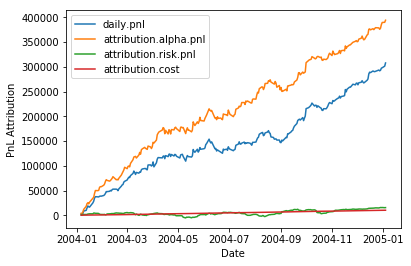

In [77]:
attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

## Build portfolio characteristics (TODO)
Calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.

In the code below, in the function `build_portfolio_characteristics` calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.  

In [1]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']
        
        
        df.at[dt,"long"] = np.sum(h[h>0])
        df.at[dt,"short"] =  np.sum(h[h<0])
        df.at[dt,"net"] = np.sum(h)
        df.at[dt,"gmv"] = np.sum(np.abs(h))
        df.at[dt,"traded"] = np.sum(np.abs(tradelist['h.opt']-tradelist['h.opt.previous']))
        
    return df

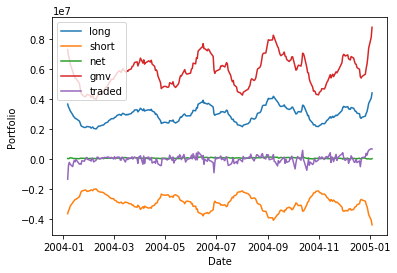

In [79]:
pchar = build_portfolio_characteristics()

for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()